# Lab Assignment Seven: Recurrent Network Architectures

Group: Nick Benso & Benjamin Kuo

In this lab, you will select a prediction task to perform on your dataset, evaluate a recurrent architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

## Dataset Selection
Select a dataset that is text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

Dataset Link: https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/input

## Preparation (3 points total)

[2 points] Define and prepare your data set. Provide details about the source of the data. Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  Also discuss your rationale for the size and nature of your vocabulary.

[0.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[0.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.
 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

df = pd.read_csv("IMDB Dataset.csv")

In [11]:
target = df["sentiment"]
df = df.drop(columns = "sentiment")
X = df["review"].astype(str).to_numpy()
print(target.value_counts())
df

positive    550
negative    549
Name: sentiment, dtype: int64


,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...
1094,Read Eric's review again. He perfectly describ...
1095,This is an immoral and reprehensible piece of ...
1096,This is the worst movie that I have ever seen....
1097,Lame rip-off of THE QUATERMASS XPERIMENT (1955...


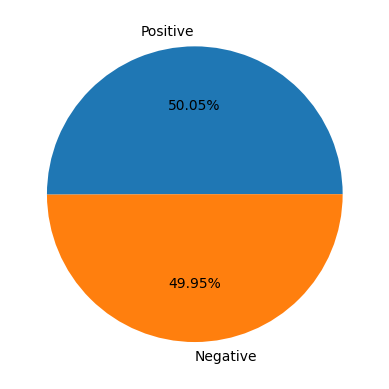

In [12]:
plt.pie(target.value_counts(),autopct="%.2f%%",labels=['Positive', 'Negative'])
plt.show()

In [13]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

target = np.unique(target, return_inverse=True)[1]

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 20013 unique tokens. Distilled to 20013 top words.
Shape of data tensor: (1099, 1000)
Shape of label tensor: (1099, 2)
20013
CPU times: total: 328 ms
Wall time: 504 ms


X_train Shape: (879, 1000) Label Shape: (879, 2)


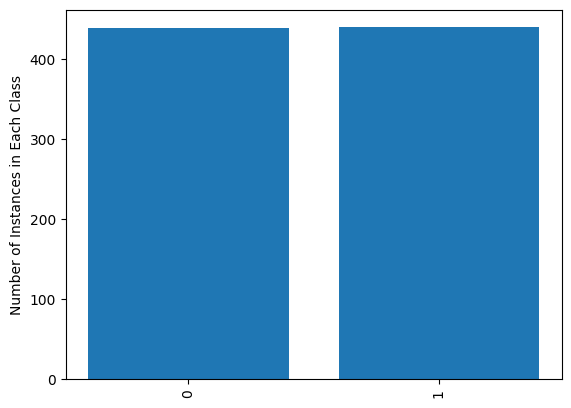

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=target, 
                                                            random_state=42)
NUM_CLASSES = 2

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(2)),uniq_classes)
plt.xticks(list(range(2)), np.unique(target), rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

## Modeling (6 points total)
[2 points] Investigate at least two different recurrent network architectures  Be sure to use an embedding layer . Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them. Justify your choice of parameters for each.

[1 point] Use the Glove pre-trained embedding. Provide justification of the embedding size.

[1 points] Using the best parameters and architecture from the RNN in the previous step, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

[0.5 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab.

[0.5 points] Run to convergence

[1 point]  Visualize the results of all the RNNs you trained. 

In [15]:
%%time
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (20014, 50) 
 Total words found: 17929 
 Percentage: 89.58229239532328
CPU times: total: 8 s
Wall time: 10.1 s


In [16]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## RNN Using LSTM #1

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1000700   
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,061,302
Trainable params: 60,602
Non-trainable params: 1,000,700
_________________________________________________________________
None


In [18]:
history = []
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=64)
history.append( tmp )

Epoch 1/12
14/14 [==============================] - 140s 9s/step - loss: 0.7014 - accuracy: 0.5267 - val_loss: 0.6984 - val_accuracy: 0.5091
Epoch 2/12
14/14 [==============================] - 68s 5s/step - loss: 0.6770 - accuracy: 0.5779 - val_loss: 0.6818 - val_accuracy: 0.5364
Epoch 3/12
14/14 [==============================] - 68s 5s/step - loss: 0.6617 - accuracy: 0.5916 - val_loss: 0.6638 - val_accuracy: 0.6318
Epoch 4/12
14/14 [==============================] - 69s 5s/step - loss: 0.6465 - accuracy: 0.6166 - val_loss: 0.6614 - val_accuracy: 0.5773
Epoch 5/12
14/14 [==============================] - 73s 5s/step - loss: 0.6326 - accuracy: 0.6598 - val_loss: 0.6862 - val_accuracy: 0.5909
Epoch 6/12
14/14 [==============================] - 69s 5s/step - loss: 0.6173 - accuracy: 0.6621 - val_loss: 0.6396 - val_accuracy: 0.6455
Epoch 7/12
14/14 [==============================] - 70s 5s/step - loss: 0.6019 - accuracy: 0.6871 - val_loss: 0.8931 - val_accuracy: 0.5000
Epoch 8/12
14/14 [=

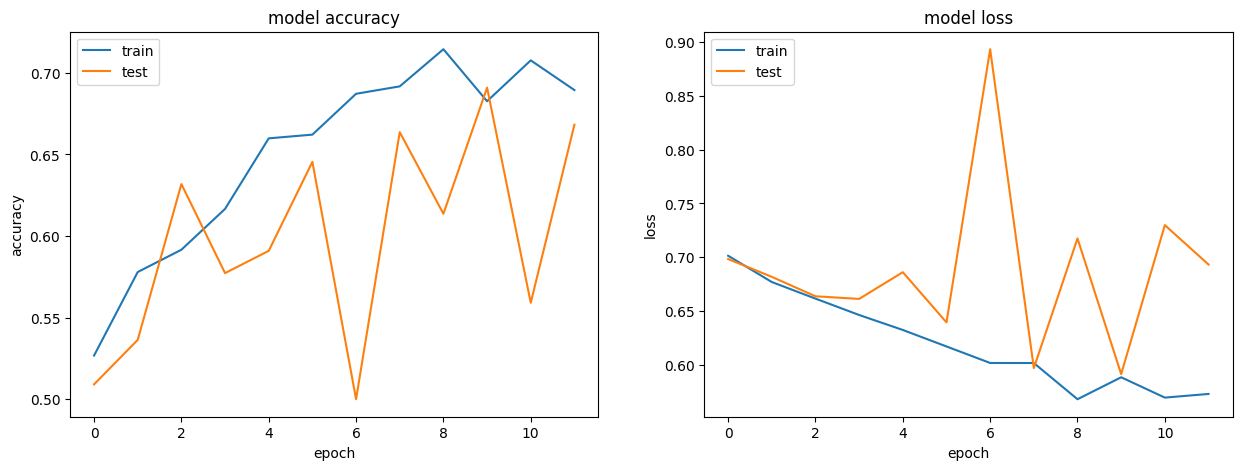

In [21]:
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## RNN Using LSTM #2

In [24]:
rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.3, recurrent_dropout=0.3))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1000700   
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,061,302
Trainable params: 60,602
Non-trainable params: 1,000,700
_________________________________________________________________
None


In [25]:
history = []
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=64)
history.append( tmp )

Epoch 1/12
14/14 [==============================] - 76s 5s/step - loss: 0.7051 - accuracy: 0.5119 - val_loss: 0.6972 - val_accuracy: 0.5091
Epoch 2/12
14/14 [==============================] - 73s 5s/step - loss: 0.6813 - accuracy: 0.5575 - val_loss: 0.6729 - val_accuracy: 0.5864
Epoch 3/12
14/14 [==============================] - 70s 5s/step - loss: 0.6586 - accuracy: 0.5859 - val_loss: 0.6939 - val_accuracy: 0.6000
Epoch 4/12
14/14 [==============================] - 71s 5s/step - loss: 0.6655 - accuracy: 0.6359 - val_loss: 0.6368 - val_accuracy: 0.6227
Epoch 5/12
14/14 [==============================] - 72s 5s/step - loss: 0.6332 - accuracy: 0.6325 - val_loss: 0.6324 - val_accuracy: 0.6545
Epoch 6/12
14/14 [==============================] - 71s 5s/step - loss: 0.6140 - accuracy: 0.6826 - val_loss: 0.6773 - val_accuracy: 0.6000
Epoch 7/12
14/14 [==============================] - 70s 5s/step - loss: 0.6063 - accuracy: 0.6735 - val_loss: 0.6160 - val_accuracy: 0.6682
Epoch 8/12
14/14 [==

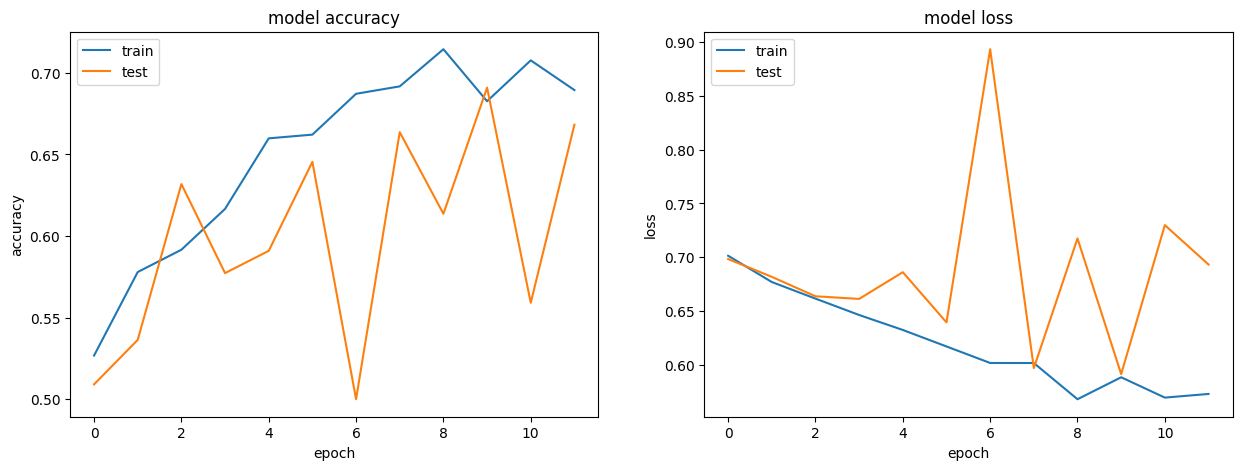

In [26]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## RNN Using GRU #1

In [29]:
from tensorflow.keras.layers import GRU

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1000700   
                                                                 
 gru_2 (GRU)                 (None, 100)               45600     
                                                                 
 dense_6 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,046,502
Trainable params: 45,802
Non-trainable params: 1,000,700
_________________________________________________________________
None


In [30]:
history = []
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=64)
history.append( tmp )

Epoch 1/12
14/14 [==============================] - 66s 5s/step - loss: 0.7169 - accuracy: 0.4801 - val_loss: 0.7060 - val_accuracy: 0.5045
Epoch 2/12
14/14 [==============================] - 62s 4s/step - loss: 0.6802 - accuracy: 0.5757 - val_loss: 0.7089 - val_accuracy: 0.5182
Epoch 3/12
14/14 [==============================] - 62s 4s/step - loss: 0.6706 - accuracy: 0.5939 - val_loss: 0.6721 - val_accuracy: 0.5727
Epoch 4/12
14/14 [==============================] - 63s 5s/step - loss: 0.6590 - accuracy: 0.6155 - val_loss: 0.6705 - val_accuracy: 0.5909
Epoch 5/12
14/14 [==============================] - 64s 5s/step - loss: 0.6487 - accuracy: 0.6223 - val_loss: 0.6770 - val_accuracy: 0.5500
Epoch 6/12
14/14 [==============================] - 62s 4s/step - loss: 0.6315 - accuracy: 0.6451 - val_loss: 0.6695 - val_accuracy: 0.6045
Epoch 7/12
14/14 [==============================] - 63s 4s/step - loss: 0.6428 - accuracy: 0.6439 - val_loss: 0.6616 - val_accuracy: 0.6000
Epoch 8/12
14/14 [==

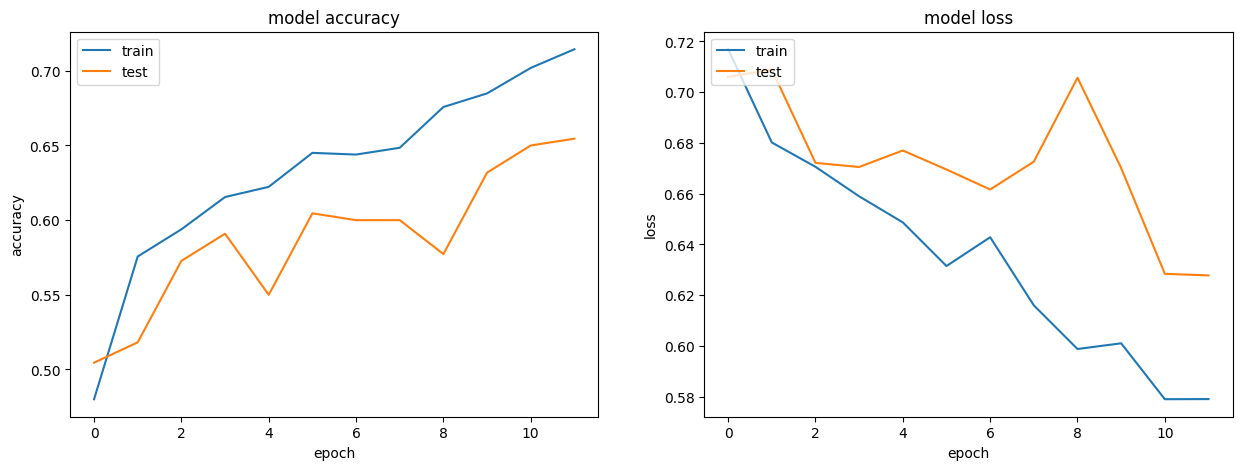

In [32]:
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## RNN Using GRU #2

In [33]:
rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(GRU(100,dropout=0.1, recurrent_dropout=0.1))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1000700   
                                                                 
 gru_3 (GRU)                 (None, 100)               45600     
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,046,502
Trainable params: 45,802
Non-trainable params: 1,000,700
_________________________________________________________________
None


In [34]:
history = []
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=64)
history.append( tmp )

Epoch 1/12
14/14 [==============================] - 68s 5s/step - loss: 0.7126 - accuracy: 0.4994 - val_loss: 0.6824 - val_accuracy: 0.5545
Epoch 2/12
14/14 [==============================] - 69s 5s/step - loss: 0.6720 - accuracy: 0.5609 - val_loss: 0.6731 - val_accuracy: 0.5682
Epoch 3/12
14/14 [==============================] - 67s 5s/step - loss: 0.6626 - accuracy: 0.5893 - val_loss: 0.6819 - val_accuracy: 0.5591
Epoch 4/12
14/14 [==============================] - 62s 4s/step - loss: 0.6558 - accuracy: 0.6200 - val_loss: 0.6664 - val_accuracy: 0.6045
Epoch 5/12
14/14 [==============================] - 64s 5s/step - loss: 0.6414 - accuracy: 0.6246 - val_loss: 0.6778 - val_accuracy: 0.5591
Epoch 6/12
14/14 [==============================] - 65s 5s/step - loss: 0.6298 - accuracy: 0.6496 - val_loss: 0.6696 - val_accuracy: 0.5773
Epoch 7/12
14/14 [==============================] - 62s 4s/step - loss: 0.6210 - accuracy: 0.6633 - val_loss: 0.6595 - val_accuracy: 0.6045
Epoch 8/12
14/14 [==

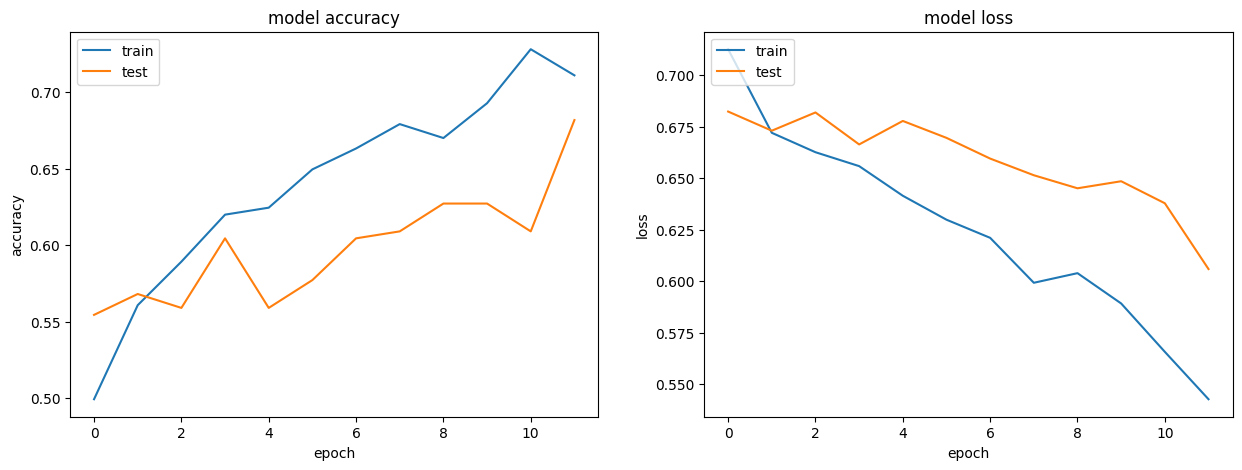

In [35]:
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Best RNN Model with a Second Chain

In [38]:
input_shape = (MAX_ART_LEN,)

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(GRU(100,dropout=0.1, recurrent_dropout=0.1, input_shape=input_shape, return_sequences=True))
rnn.add(GRU(50,dropout=0.1, recurrent_dropout=0.1))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1000700   
                                                                 
 gru_8 (GRU)                 (None, 1000, 100)         45600     
                                                                 
 gru_9 (GRU)                 (None, 50)                22800     
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 1,069,202
Trainable params: 68,502
Non-trainable params: 1,000,700
_________________________________________________________________
None


In [39]:
history = []
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=12, batch_size=64)
history.append( tmp )

Epoch 1/12
14/14 [==============================] - 153s 9s/step - loss: 0.7095 - accuracy: 0.5290 - val_loss: 0.6929 - val_accuracy: 0.5273
Epoch 2/12
14/14 [==============================] - 125s 9s/step - loss: 0.6798 - accuracy: 0.5711 - val_loss: 0.6679 - val_accuracy: 0.5818
Epoch 3/12
14/14 [==============================] - 130s 9s/step - loss: 0.6626 - accuracy: 0.6041 - val_loss: 0.6751 - val_accuracy: 0.5727
Epoch 4/12
14/14 [==============================] - 131s 9s/step - loss: 0.6555 - accuracy: 0.6064 - val_loss: 0.6673 - val_accuracy: 0.5727
Epoch 5/12
14/14 [==============================] - 138s 10s/step - loss: 0.6492 - accuracy: 0.6337 - val_loss: 0.6626 - val_accuracy: 0.6091
Epoch 6/12
14/14 [==============================] - 133s 10s/step - loss: 0.6473 - accuracy: 0.6268 - val_loss: 0.6766 - val_accuracy: 0.5864
Epoch 7/12
14/14 [==============================] - 133s 9s/step - loss: 0.6231 - accuracy: 0.6394 - val_loss: 0.6686 - val_accuracy: 0.5909
Epoch 8/12


## Exceptional Work (1 points total)
You have free rein to provide additional analyses.

One idea (required for 7000 level students to do one of these options):

Research and use the ConceptNet, Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 

Another Idea (NOT required): Try to create a RNN for generating novel text. 
nd GRU). 

Alternatively, you may also choose one recurrent network and one convolutional network.